### 전이 학습(Transfer Learning)

전이 학습은 한 가지 문제에 대해 학습한 기능을 가져와서 비슷한 새로운 문제에 활용하는 것으로 구성됩니다

<img src = 'https://miro.medium.com/v2/resize:fit:720/format:webp/1*7ZD-u-h8hFPuN2PYJvLMBw.png'>

###### Image by <a href ='https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751'>Transfer learning from pre-trained models</a>


딥 러닝의 맥락에서 전이 학습의 가장 일반적인 구현은 다음 워크플로와 같습니다.

- 이전에 훈련된 모델에서 레이어를 가져옵니다.
- 추후 훈련 라운드 중에 포함된 정보가 손상되지 않도록 동결합니다.
- 고정된 레이어 위에 훈련할 수 있는 새 레이어를 추가합니다. 해당 레이어는 기존 기능을 새로운 데이터세트에 대한 예측으로 전환하는 방법을 배웁니다.
- 데이터세트에서 새로운 레이어를 훈련합니다.
- 마지막으로 선택적인 단계는 미세 조정입니다

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

#### 레이어 동결: trainable 속성의 이해

<image src = 'https://idiotdeveloper.com/wp-content/uploads/2021/08/transfer-learning-model.png'>

###### Image by <a href = 'https://idiotdeveloper.com/what-is-transfer-learning-an-introduction/'>What is Transfer Learning? – A Simple Introduction.</a>
-------------
레이어 및 모델에는 세 가지 가중치 속성이 있습니다.

**weights**
- 레이어의 모든 가중치 변수 목록입니다.

**trainable_weights**
- 훈련 중 손실을 최소화하기 위해 업데이트(그래디언트 디센트를 통해)되어야 하는 목록입니다.

**non_trainable_weights**
- 훈련되지 않은 가중치 변수의 목록입니다. 일반적으로 순방향 전달 중에 모델에 의해 업데이트됩니다.


In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


레이어 및 모델에는 boolean 속성 trainable도 있습니다. 값은 변경될 수 있습니다.

layer.trainable을 False로 설정하면 모든 레이어의 가중치가 훈련 가능에서 훈련 불가능으로 이동합니다. 이를 레이어 "**동결**"이라고 합니다.

In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


훈련 가능한 가중치가 훈련할 수 없게 되면 훈련 중에 그 값이 더는 업데이트되지 않습니다.



In [ ]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - 5s 5s/step - loss: 0.0993


### 일반적인 전이 학습 워크플로

- 기본 모델을 인스턴스화하고 사전 훈련된 가중치를 여기에 로드합니다.
- trainable = False를 설정하여 기본 모델의 모든 레이어를 동결합니다.
- 기본 모델에서 하나 이상의 레이어 출력 위에 새 모델을 만듭니다.
- 새 데이터세트에서 새 모델을 훈련합니다.



In [ ]:
# 먼저, 사전 훈련된 가중치를 사용하여 기본 모델을 인스턴스화합니다
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
# 그런 다음 기본 모델을 동결합니다.
base_model.trainable = False

In [ ]:
# 맨 위에 새 모델을 만듭니다.
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False) # Freeze
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
# 새 데이터로 모델을 훈련합니다.
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
# model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)

### 미세 조정

모델이 새로운 데이터에 수렴하면 기본 모델의 일부 또는 전부를 동결 해제하고 학습률이 매우 낮은 전체 모델을 전체적으로 재훈련할 수 있습니다.

이 단계는 선택적으로 마지막 단계이며 점진적으로 개선할 수 있습니다. 또한 잠재적으로 빠른 과대적합을 초래할 수 있습니다. 명심하세요.

동결된 레이어가 있는 모델이 수렴하도록 훈련된 후에만 이 단계를 수행하는 것이 중요합니다. 무작위로 초기화된 훈련 가능한 레이어를 사전 훈련된 특성을 보유하는 훈련 가능한 레이어와 혼합하는 경우, 무작위로 초기화된 레이어는 훈련 중에 매우 큰 그래디언트 업데이트를 유발하여 사전 훈련된 특성을 파괴합니다.

또한 이 단계에서는 일반적으로 매우 작은 데이터 집합에서 첫 번째 훈련보다 훨씬 더 큰 모델을 훈련하기 때문에, 매우 낮은 학습률을 사용하는 것이 중요합니다. 결과적으로 큰 가중치 업데이트를 적용하면 과도하게 빠른 과대적합의 위험이 있습니다. 여기에서는 사전 훈련된 가중치만 점진적인 방식으로 다시 적용하려고 합니다.



In [ ]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

### 고양이 vs 개 데이터세트에서 이미지 분류

---

전이 학습은 매우 작은 데이터로 작업할 때 가장 유용합니다.

 데이터세트를 작게 유지하기 위해 원래 훈련 데이터(25,000개 이미지)의 40%를 훈련에, 10%를 유효성 검사에, 10%를 테스트에 사용합니다.

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


레이블 1이 "개"이고 레이블 0이 "고양이"임을 알 수 있습니다.

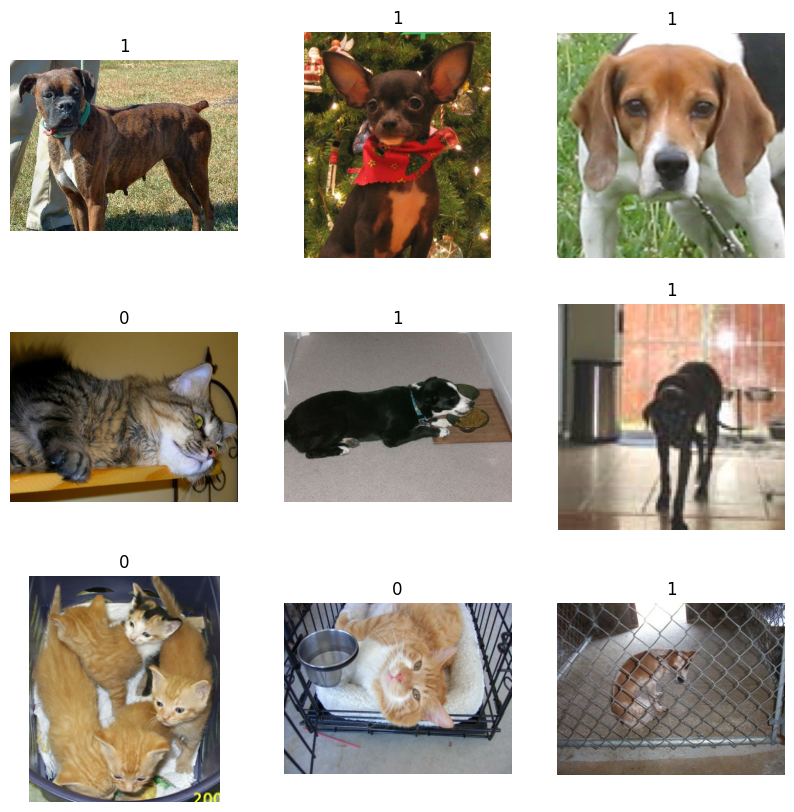

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

#### 데이터 표준화하기
원시 이미지는 다양한 크기를 가지고 있습니다.또한 각 픽셀은 0에서 255 사이의 3개의 정숫값(RGB 레벨값)으로 구성됩니다.

이는 신경망에 공급하기 적합하지 않습니다. 2가지를 수행해야 합니다.

- 고정된 이미지 크기로 표준화합니다. 150x150을 선택합니다.
- 정상 픽셀 값은 -1 과 1 사이입니다. 모델 자체의 일부로 Normalization 레이어를 사용합니다.

여기에서는 데이터 파이프라인에서 이미지 크기 조정을 수행하고(심층 신경망은 인접한 데이터 배치만 처리할 수 있기 때문에) 입력값 스케일링을 모델의 일부로 생성합니다.

이미지 크기를 150x150으로 조정해 보겠습니다.



In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

또한 데이터를 일괄 처리하고 캐싱 및 프리페치를 사용하여 로딩 속도를 최적화합니다.



In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

#### 무작위 데이터 증강 사용하기

큰 이미지 데이터세트가 없는 경우 임의의 수평 뒤집기 또는 작은 임의의 회전과 같이 훈련 이미지에 무작위이지만 사실적인 변형을 적용하여 샘플 다양성을 인위적으로 도입하는 것이 좋습니다.

이것은 과대적합을 늦추면서 모델을 훈련 데이터의 다른 측면에 노출하는 데 도움이 됩니다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

다양한 무작위 변형 후 첫 번째 배치의 첫 번째 이미지가 어떻게 보이는지 시각화해 보겠습니다.



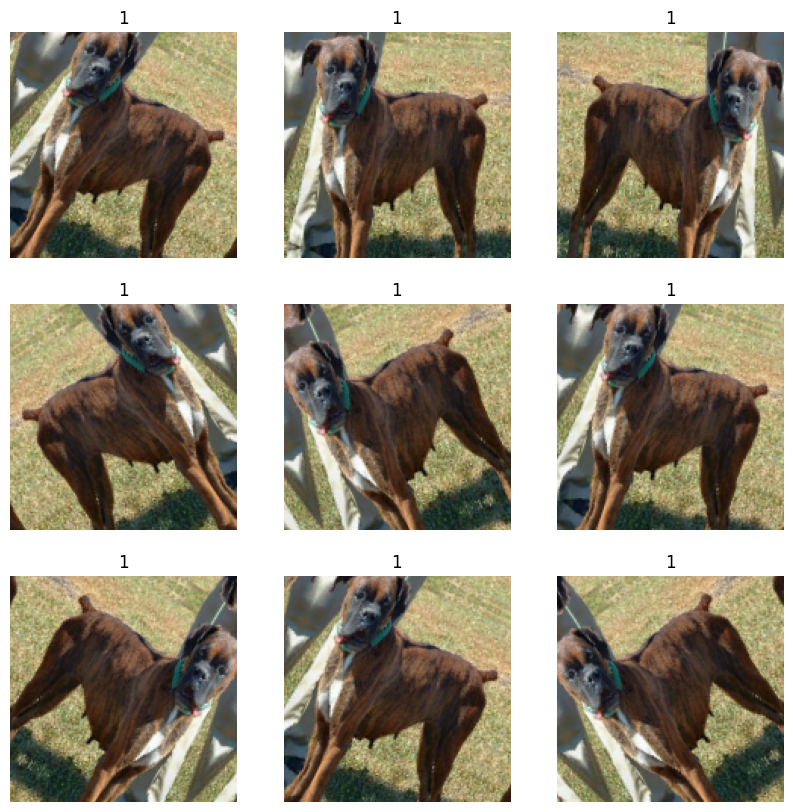

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

#### 모델 빌드하기

- 입력 값(처음에는 [0, 255] 범위)을 [-1, 1] 범위로 조정하기 위해 Rescaling 레이어를 추가합니다.
- 정규화를 위해 분류 레이어 앞에 Dropout 레이어를 추가합니다.
- 기본 모델을 호출할 때 training=False를 전달하여 추론 모드에서 실행되므로 미세 조정을 위해 기본 모델을 동결 해제한 후에도 batchnorm 통계가 업데이트되지 않습니다.

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

#### 최상위 레이어 훈련하기

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 40s 95ms/step - loss: 0.1687 - binary_accuracy: 0.9240 - val_loss: 0.0833 - val_binary_accuracy: 0.9678
Epoch 2/20
291/291 [==============================] - 25s 85ms/step - loss: 0.1164 - binary_accuracy: 0.9496 - val_loss: 0.0748 - val_binary_accuracy: 0.9690
Epoch 3/20
291/291 [==============================] - 25s 84ms/step - loss: 0.1038 - binary_accuracy: 0.9569 - val_loss: 0.0734 - val_binary_accuracy: 0.9682
Epoch 4/20
291/291 [==============================] - 24s 84ms/step - loss: 0.1050 - binary_accuracy: 0.9558 - val_loss: 0.0704 - val_binary_accuracy: 0.9738
Epoch 5/20
291/291 [==============================] - 24s 82ms/step - loss: 0.1070 - binary_accuracy: 0.9550 - val_loss: 0.0691 - val_binary_accuracy: 0.9721
Epoch 6/20
291/291 [==============================] - 24s 82ms/step - loss: 0.1022 - binary_accuracy: 0.9593 - val_loss: 0.0703 - val_binary_accuracy: 0.9725
Epoch 7/20
291/291 [==============================] 

#### 전체 모델의 미세 조정 수행하기

마지막으로 기본 모델을 동결 해제하고 낮은 학습률로 전체 모델을 전체적으로 훈련합니다.

중요한 것은 기본 모델이 훈련 가능하지만 모델 빌드를 호출할 때 training=False를 전달했으므로 여전히 추론 모드로 실행되고 있다는 것입니다.

이는 내부의 배치 정규화 레이어가 배치 통계를 업데이트하지 않음을 의미합니다. 만약 레이어가 배치 통계를 업데이트한다면 지금까지 모델이 학습한 표현에 혼란을 줄 수 있습니다.


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             